<div>
<img src="https://i.ibb.co/v3CvVz9/udd-short.png" width="150"/>
    <br>
    <strong>Universidad del Desarrollo</strong><br>
    <em>Magíster en Data Science</em><br>
    <em>Asignatura Almacenamiento y Captura de Datos</em><br>
    <em>Profesor: Carlos Perez </em><br>

</div>

# **Proyecto: Portal Inmobiliario**

*27 de Diciembre de 2024*

**Nombre Estudiante(s)**: Joaquin Leiva - Victor Saldivia Vera - Cristian Tobar - Constanza Perez

- **Objetivo:** Medir el conocimiento aprendido de base de datos, web scraping y APIs. Para esto se solicita desarrollar
un sencillo producto de consulta de inmuebles con sus comercios cercano.

- **Información Importante:** Para mayor información respecto al repositorio del proyecto visitar: [Repositorio WebScraping-APIs-BD](https://github.com/Vikktor93/webscraping-api-bd-project) 

### **IMPORTACIÓN DE LIBRERÍAS**

In [6]:
import sqlite3
from dotenv import load_dotenv
import os 
import time
import re
import requests
import pandas as pd
from IPython.display import Image
from selenium import webdriver
from selenium.webdriver.firefox.service import Service as FirefoxService
from webdriver_manager.firefox import GeckoDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException, TimeoutException


# **PARTE 1**

### **VARIABLES**

In [2]:
# Cargar variable desde .env
load_dotenv()

True

In [3]:
# Acceder a la API_KEY
api_key = os.getenv("api_key")

In [4]:
op_contrato = 'arriendo'  # opciones: venta, arriendo, arriendo_temporal
op_inmueble = 'departamentos'  # opciones: dpto, casa, oficina
ubicacion_inmueble = 'las condes'
monto_minimo = 500000
monto_maximo = 600000
cant_paginas = 3
radio_busqueda = '300' # valor en metros
busqueda_rubros = ['restaurante', 'supermercado']

### **WEBSCRAPING**

#### **Inicialización del WebDriver y Navegación a la Página**

Se inicia el WebDriver de Firefox utilizando `GeckoDriverManager` para descargar automáticamente la versión más reciente del controlador. Además, se maximiza la ventana del navegador para asegurar que todos los elementos sean visibles y evitar errores por elementos no interactuables. Se añade un retraso de 4 segundos para garantizar que la página web del portal inmobiliario se cargue completamente antes de realizar cualquier acción.

In [5]:
# Inicializa WebDriver 
driver = webdriver.Firefox(service=FirefoxService(GeckoDriverManager().install()))

# Maximiza la ventana
driver.maximize_window()

# Navega al sitio
url = "https://www.portalinmobiliario.com/"
driver.get(url)
time.sleep(4)

#### **Búsqueda de Información - Filtros de Búsqueda**

En el siguiente bloque de código se automatiza la selección de filtros en el Portal Inmobiliario. Se simula el comportamiento de un usuario al seleccionar el tipo de contrato, tipo de propiedad e ingresar la comuna o ciudad deseada. Por último, si ocurre algún error durante la interacción con los filtros, el `try-except` captura el error y lo imprime.

In [6]:
# Interactua con los filtros
try:
    # Filtrar por tipo de contrato
    contrato_boton = driver.find_element(By.XPATH, "//button[@aria-label='Tipo de operación']")
    contrato_boton.click()
    
    # Selecciona el tipo de contrato (Venta, Arriendo, Arriendo Temporal)
    driver.find_element(By.XPATH, f"//span[contains(text(), '{op_contrato.capitalize()}')]").click()

    # Filtra por tipo de inmueble
    inmueble_boton = driver.find_element(By.XPATH, "//button[@aria-label='Tipo de propiedad']")
    inmueble_boton.click()
    
    # Selección del tipo de inmueble (Departamento, Casa, Oficina)
    driver.find_element(By.XPATH, f"//span[contains(text(), '{op_inmueble.capitalize()}')]").click()

    # Filtra por comuna y buscar
    comuna_input = driver.find_element(By.XPATH, "//input[@placeholder='Ingresa comuna o ciudad']")
    comuna_input.send_keys(ubicacion_inmueble)
    time.sleep(2)
    comuna_input.send_keys(Keys.ENTER)

    # Clic en botón buscar con espera de tiempo
    boton_buscar = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.XPATH, "//span[@class='andes-button__content' and contains(text(), 'Buscar')]"))
    )
    boton_buscar.click()
    
except Exception as e:
    print("Error durante la interacción", e)

#### **Filtro de Precios**

Se utiliza `WebDriverWait` para asegurarse de que los campos de filtro de precios estén completamente cargados antes de interactuar con ellos. Se identifican los campos para ingresar el precio mínimo y máximo utilizando `XPath` con el atributo `data-testid`.

In [7]:
# Se espera a que cargue la página de resultados
WebDriverWait(driver, 10).until(
    EC.presence_of_element_located((By.XPATH, "//input[@data-testid='Minimum-price']"))
)

# Filtro por monto mínimo y monto máximo
minimo_input = driver.find_element(By.XPATH, "//input[@data-testid='Minimum-price']")
maximo_input = driver.find_element(By.XPATH, "//input[@data-testid='Maximum-price']")

minimo_input.clear()
minimo_input.send_keys(str(monto_minimo))

maximo_input.clear()
maximo_input.send_keys(str(monto_maximo))
maximo_input.send_keys(Keys.ENTER)

#### **Función de Scroll**

Se crea una función que realiza el desplazamiento automático hacia el final de la página utilizando `window.scrollTo`.

In [8]:
def scroll_down(driver):
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(3)

#### **Extracción y Almacenamiento de Resultados**

En la primera parte del código, se crea un lissta vacía llamada `resultados`, para almacenar los datos extraídos de cada anuncio. Todo esto dentro de un bucle `for`, que va a recorrer el número de páginas definido por la variable `cant_paginas`. Luego, se invoca la función scroll_down para que todos los anuncios sean visibles en cada página. 

Se identifican los anuncios mediante `find_elements` con `XPath` que apunta a los elementos `li` de clase `ui-search-layout__item`. En la parte de iteración sobre los anuncios, se creó un bucle `while` que itera sobre cada anuncio en la página. Luego, se vuelve a recolectar la lista de anuncios después de cada interacción para asegurar que los elementos sean accesibles en cada ciclo. Se realiza además, una gestión del índice `i` en la iteración de anuncios, para que el código continúe ejecutándose sin interrupciones, incluso si ocurren cambios dinámicos en la página web durante la extracción de datos. 

Para evitar que se abran nuevas pestañas, se modifica el comportamiento del clic utilizando `arguments[0].target`, esto asegura que el anuncio se abra en la misma pestaña.

En la extracción de datos de cada anuncio, Se espera hasta que el título del anuncio esté completamente cargado `ui-pdp-title`, para luego capturar tanto el título, como el precio, moneda, enlace y la dirección completa. Para este último elemento en caso de error o no encontrado, se asigna como "No Disponible".

Una vez hecha la captura de la información, se regresa a la página de resultado utilizando `driver.back()`, y se vuelve a invocar la función `scroll_down(driver)` para asegurar que todos los anuncios estén visibles.

Para la parte de navegación entre páginas se utiliza un condicional `if`, donde se analiza, si no es la última página, se intenta hacer clic en el botón de paginación, además se agrega un manejo de errores en caso de que el botón "Siguiente" no se encuentra o no es clicable, se imprime un mensaje de error y el bucle se interrumpe (`break`).

Finalizando, se crea el DataFrame con pandas, el cual tiene las siguientes columnas: 
- **Título:** Nombre del inmueble.
- **Moneda:** Tipo de moneda (CLP o UF).
- **Precio:** Precio del inmueble.
- **Dirección:** Ubicación del inmueble.
- **Enlace:** URL del anuncio.


In [24]:
resultados = []

for pagina in range(cant_paginas):
    scroll_down(driver)

    WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.XPATH, "//li[contains(@class, 'ui-search-layout__item')]"))
    )
    anuncios = driver.find_elements(By.XPATH, "//li[contains(@class, 'ui-search-layout__item')]")

    i = 0
    while i < len(anuncios):
        try:
            anuncios = driver.find_elements(By.XPATH, "//li[contains(@class, 'ui-search-layout__item')]//a")

            if i >= len(anuncios):
                break

            # Hacer clic en el anuncio sin abrir una nueva pestaña
            driver.execute_script("arguments[0].target='_self'; arguments[0].click();", anuncios[i])
            
            WebDriverWait(driver, 15).until(
                EC.presence_of_element_located((By.CLASS_NAME, 'ui-pdp-title'))
            )

            # Extracción de datos
            try:
                titulo = driver.find_element(By.XPATH, "//h1[@class='ui-pdp-title']").text
            except:
                titulo = "No disponible"
            
            precio = driver.find_element(By.XPATH, "//span[@class='andes-money-amount__fraction']").text
            moneda = driver.find_element(By.XPATH, "//span[@class='andes-money-amount__currency-symbol']").text
            link = driver.current_url

            try:
                direccion = driver.find_element(
                    By.XPATH, "//div[@class='ui-vip-location']//p[contains(@class, 'ui-pdp-media__title')]"
                ).text
            except:
                direccion = "No disponible"

            resultados.append([titulo, moneda, precio, direccion, link])

            # Volver a la página anterior sin abrir nueva pestaña
            driver.back()
            
            scroll_down(driver)

            WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.XPATH, "//li[contains(@class, 'ui-search-layout__item')]"))
            )

            i += 1

        except Exception as e:
            print(f"Error al extraer datos del anuncio: {e}")
            i += 1
            continue

    if pagina < cant_paginas - 1:
        try:
            siguiente_boton = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.XPATH, "//li[contains(@class, 'andes-pagination__button--next')]/a"))
            )
            siguiente_boton.click()

            WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.XPATH, "//li[contains(@class, 'ui-search-layout__item')]"))
            )
        except Exception as e:
            print(f"No se encontró el botón 'Siguiente' o no se pudo hacer clic: {e}")
            break

df = pd.DataFrame(resultados, columns=['Título', 'Moneda', 'Precio', 'Dirección', 'Enlace'])


NameError: name 'cant_paginas' is not defined

#### **Impresión del Dataframe**

Para mostrar el DataFrame completo con todos los resultados obtenidos durante el proceso de scraping, se utiliza `pd.set_option('display.max_rows', None)` que permite se mostrar todas las filas del DataFrame, sin truncar los resultados.

In [10]:
pd.set_option('display.max_rows', None)
df

,Título,Moneda,Precio,Dirección,Enlace
0,Somma Parque Bustamante - Metro Irarrázaval Ñuñoa,$,518.140,"San Eugenio 401, Parque San Eugenio - Metro Ñu...",https://www.portalinmobiliario.com/arriendo/de...
1,IMU San Cristóbal,UF,14,"Inés Matte Urrejola 900, Providencia, Las Cond...",https://www.portalinmobiliario.com/arriendo/de...
2,Activa Juan Mitjans,$,550.000,"Juan Mitjans 135, Metro Rodrigo de Araya, Macu...",https://www.portalinmobiliario.com/arriendo/de...
3,Arriendo Depto a pasos del Metro Chile-España ...,$,500.700,"Av. Irarrázaval 2899, Plaza Ñuñoa, Ñuñoa, RM (...",https://www.portalinmobiliario.com/arriendo/de...
4,INSITU Irarrázaval,$,504.824,"Avenida Irarrázaval 2100 - 2400, Metro Ñuñoa, ...",https://www.portalinmobiliario.com/arriendo/de...
5,Nomad Bellet,UF,13,"Antonio Bellet 126, Providencia, Pedro de Vald...",https://www.portalinmobiliario.com/arriendo/de...
6,Arriendo Departamento Nuevo 2d+2b Avenida Espa...,$,530.000,"Av. España 702, Santiago, Barrio República, Sa...",https://www.portalinmobiliario.com/MLC-1556326...
7,"Arriendo 2d+2b Carmen 121, Metro Santa Lucía",$,500.000,"Carmen 121, Santiago, Santa Isabel, Santiago, ...",https://www.portalinmobiliario.com/MLC-2808039...
8,"Departamento En Viña 2d2b Mariposa , Ubicación...",$,570.000,"Álvarez 1 - 300, Viña Del Mar, Valparaíso, Agu...",https://www.portalinmobiliario.com/MLC-1565454...
9,Departamento En Arriendo De 2 Dorm. En Concepción,$,500.000,"Orompello 1470, Concepción, Barrio Poniente, C...",https://www.portalinmobiliario.com/MLC-2814801...


 Para finalizar la sesión de Selenium WebDriver y cerrar el navegador, se utiliza `driver.quit()` que cierra todas las pestañas abiertas del navegador y finaliza completamente el proceso del WebDriver. Es importante ejecutar esta línea al finalizar el scraping para liberar los recursos del sistema y evitar que queden instancias del navegador ejecutándose en segundo plano.

In [11]:
# Cierra el WebDriver principal
driver.quit()

#### **Obtención del valor de la UF**

Se inicia una nueva sesión de Selenium WebDriver (`driver_uf`) exclusivamente para obtener el valor de la UF. Se espera hasta que el elemento con la clase `vpr` que contiene el valor de la UF, esté disponible y se extrae su texto. Luego, el valor extraído es procesado para eliminar símbolos ($), puntos y comas, para convertirlo en un formato flotante con `float()`. La función devuelve el valor de la UF en CLP como un número flotante.

In [12]:
# Nueva sesión de WebDriver para obtener la UF
def obtener_valor_uf():
    driver_uf = webdriver.Firefox(service=FirefoxService(GeckoDriverManager().install()))
    driver_uf.get("https://valoruf.cl/")
    time.sleep(3)
    valor_uf = WebDriverWait(driver_uf, 10).until(
        EC.presence_of_element_located((By.CLASS_NAME, "vpr"))
    ).text
    driver_uf.quit()
    valor_uf = float(valor_uf.replace('$', '').replace('.', '').replace(',', '.'))
    return valor_uf

#### **Valor de la UF**

Se almacena el valor de la UF en la variable `valor_uf` y se muestra el valor actual de la UF.

In [13]:
valor_uf = obtener_valor_uf()
print(f"Valor de la UF hoy: {valor_uf} CLP")

Valor de la UF hoy: 38438.98 CLP


#### **Convertir valores en UF a CLP**

Una vez con el valor de la UF almacenado, se debe convertir los precios expresados en UF a CLP. Se recorre cada fila del DataFrame (`df`) usando `.iterrows()`.
Se agrega una condicional, donde se evalúa, si la moneda del anuncio es UF, se procede a calcular el valor en pesos chilenos (CLP). El valor del campo `Precio` es transformado eliminando los puntos `(.)` con `replace()` para facilitar el cálculo. Luego, se multiplica el precio en UF por el valor de la UF, redondeando el valor y se convierte a entero usando `int()`.

Por último, el precio en CLP se actualiza en la columna `Precio` usando `.at[index]`. La moneda se cambia de UF a $ para reflejar la conversión.


In [14]:
for index, row in df.iterrows():
    if row['Moneda'] == 'UF':
        # Calcular el valor en CLP
        precio_en_clp = float(row['Precio'].replace('.', '')) * valor_uf
        
        # Redondear y convertir a entero
        df.at[index, 'Precio'] = int(round(precio_en_clp))
        df.at[index, 'Moneda'] = '$'

#### **Actualización de Moneda a Símbolo de Pesos ($)**


Se reemplaza el CLP en la columna `Moneda` del DataFrame por el símbolo $, utilizando el método `replace()`, con el objetivo de estandarizar el formato para representar pesos chilenos.

In [15]:
df['Moneda'] = df['Moneda'].replace({'CLP': '$'})

#### **Normalización de Precios**

Se estandariza los valores en la columna `Precio` eliminando los puntos separadores de miles y convirtiendo los valores a enteros. El primer paso es, convertir la columna `Precio` a tipo `str` (cadena de texto) usando `.astype(str)`. Luego, se eliminan los puntos (.) que separan miles mediante `.str.replace('.', '')`. Se convierte el resultado en tipo `float` utilizando `.astype(float)`, para que finalmente, se convierte el valor flotante a `int` para asegurar que el precio esté representado sin decimales.

In [16]:
df['Precio'] = df['Precio'].astype(str).str.replace('.', '').astype(float).astype(int)

#### **Impresión Dataframe**

In [17]:
pd.set_option('display.max_rows', None)
df

,Título,Moneda,Precio,Dirección,Enlace
0,Somma Parque Bustamante - Metro Irarrázaval Ñuñoa,$,518140,"San Eugenio 401, Parque San Eugenio - Metro Ñu...",https://www.portalinmobiliario.com/arriendo/de...
1,IMU San Cristóbal,$,538146,"Inés Matte Urrejola 900, Providencia, Las Cond...",https://www.portalinmobiliario.com/arriendo/de...
2,Activa Juan Mitjans,$,550000,"Juan Mitjans 135, Metro Rodrigo de Araya, Macu...",https://www.portalinmobiliario.com/arriendo/de...
3,Arriendo Depto a pasos del Metro Chile-España ...,$,500700,"Av. Irarrázaval 2899, Plaza Ñuñoa, Ñuñoa, RM (...",https://www.portalinmobiliario.com/arriendo/de...
4,INSITU Irarrázaval,$,504824,"Avenida Irarrázaval 2100 - 2400, Metro Ñuñoa, ...",https://www.portalinmobiliario.com/arriendo/de...
5,Nomad Bellet,$,499707,"Antonio Bellet 126, Providencia, Pedro de Vald...",https://www.portalinmobiliario.com/arriendo/de...
6,Arriendo Departamento Nuevo 2d+2b Avenida Espa...,$,530000,"Av. España 702, Santiago, Barrio República, Sa...",https://www.portalinmobiliario.com/MLC-1556326...
7,"Arriendo 2d+2b Carmen 121, Metro Santa Lucía",$,500000,"Carmen 121, Santiago, Santa Isabel, Santiago, ...",https://www.portalinmobiliario.com/MLC-2808039...
8,"Departamento En Viña 2d2b Mariposa , Ubicación...",$,570000,"Álvarez 1 - 300, Viña Del Mar, Valparaíso, Agu...",https://www.portalinmobiliario.com/MLC-1565454...
9,Departamento En Arriendo De 2 Dorm. En Concepción,$,500000,"Orompello 1470, Concepción, Barrio Poniente, C...",https://www.portalinmobiliario.com/MLC-2814801...


#### **Normalización de Dirección**

Esta parte es importante, ya que se debe normalizar las direcciones que contienen rangos de numeración (por ejemplo, 2100 - 2400) para obtener un solo número representativo, facilitando la geocodificación y evitando errores en el uso de la API más adelante.

Primero, se reemplaza el guion largo (–) por el guion estándar (-) para uniformidad. Luego, se extraen todos los números de la dirección utilizando `re.findall(r'\d+', direccion)`. Si hay al menos dos números, se calcula el promedio del primer y segundo número. Por último, se reemplaza el rango completo en la dirección con el número promedio usando `re.sub()`.

In [18]:
# Función que calcula el promedio entre el primer y segundo número
def normalizar_direccion(direccion):
    # Reemplazar guion largo por guion normal para unificar el formato
    direccion = direccion.replace('–', '-')
    
    # Encontrar todos los números en la dirección
    numeros = re.findall(r'\d+', direccion)
    
    if len(numeros) >= 2:
        # Calcular el promedio entre el primer y segundo número
        promedio = int((int(numeros[0]) + int(numeros[1])) / 2)
        # Reemplazar el rango completo con el número promedio
        direccion = re.sub(r'\d+\s*-\s*\d+', str(promedio), direccion)
    
    return direccion

#### **Impresión Dataframe Final conn Direcciones Normalizadas**

Se aplica la función `normalizar_direccion(direccion)` a cada fila de la columna Dirección del DataFrame `df`. Luego, se utiliza el método `apply()`, que aplica la función de normalización de dirección, fila por fila. Las direcciones normalizadas reemplazan las originales en la misma columna `Dirección`.

In [19]:
df['Dirección'] = df['Dirección'].apply(normalizar_direccion)

In [20]:
pd.set_option('display.max_rows', None)
df

,Título,Moneda,Precio,Dirección,Enlace
0,Somma Parque Bustamante - Metro Irarrázaval Ñuñoa,$,518140,"San Eugenio 401, Parque San Eugenio - Metro Ñu...",https://www.portalinmobiliario.com/arriendo/de...
1,IMU San Cristóbal,$,538146,"Inés Matte Urrejola 900, Providencia, Las Cond...",https://www.portalinmobiliario.com/arriendo/de...
2,Activa Juan Mitjans,$,550000,"Juan Mitjans 135, Metro Rodrigo de Araya, Macu...",https://www.portalinmobiliario.com/arriendo/de...
3,Arriendo Depto a pasos del Metro Chile-España ...,$,500700,"Av. Irarrázaval 2899, Plaza Ñuñoa, Ñuñoa, RM (...",https://www.portalinmobiliario.com/arriendo/de...
4,INSITU Irarrázaval,$,504824,"Avenida Irarrázaval 2250, Metro Ñuñoa, Ñuñoa, ...",https://www.portalinmobiliario.com/arriendo/de...
5,Nomad Bellet,$,499707,"Antonio Bellet 126, Providencia, Pedro de Vald...",https://www.portalinmobiliario.com/arriendo/de...
6,Arriendo Departamento Nuevo 2d+2b Avenida Espa...,$,530000,"Av. España 702, Santiago, Barrio República, Sa...",https://www.portalinmobiliario.com/MLC-1556326...
7,"Arriendo 2d+2b Carmen 121, Metro Santa Lucía",$,500000,"Carmen 121, Santiago, Santa Isabel, Santiago, ...",https://www.portalinmobiliario.com/MLC-2808039...
8,"Departamento En Viña 2d2b Mariposa , Ubicación...",$,570000,"Álvarez 150, Viña Del Mar, Valparaíso, Agua Sa...",https://www.portalinmobiliario.com/MLC-1565454...
9,Departamento En Arriendo De 2 Dorm. En Concepción,$,500000,"Orompello 1470, Concepción, Barrio Poniente, C...",https://www.portalinmobiliario.com/MLC-2814801...


#### **Generación de CSV**

In [21]:
# Ruta del archivo
ruta_archivo = 'data/resultados_inmobiliarios.csv'

# Se verifica si el archivo ya existe
if os.path.exists(ruta_archivo):
    print("El archivo ya existe. Reemplazando archivo existente...")
else:
    print("El archivo no existe. Creando nuevo archivo...")

# Guardar el DataFrame en un archivo CSV
df.to_csv(ruta_archivo, index=False, encoding='utf-8')

print(f"Archivo guardado en: {ruta_archivo}")

El archivo ya existe. Reemplazando archivo existente...
Archivo guardado en: data/resultados_inmobiliarios.csv


# **PARTE 2**

### **GEOCODING API**

#### **Función para Consultar Geocoding API**

A continuación, se crea una función `geocod(direccion_api_key)`, que realiza consultas a la API de Google Geocoding para obtener la latitud y longitud, así como el identificador único del lugar (place_id) basado en una dirección.

In [22]:
"""
    Args de la función:
        direccion (str): Dirección a consultar.
        api_key (str): Clave de la API de Google.
        max_retries (int): Número máximo de reintentos en caso de error.

    Returns:
        tuple: (latitud, longitud, place_id) o (None, None, None) si ocurre un error.
"""

def geocod(direccion, api_key, max_retries=3):
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    parametros = {
        "address": direccion,
        "key": api_key
    }
    retries = 0

    while retries < max_retries:
        try:
            respuesta = requests.get(base_url, params=parametros, timeout=10)
            respuesta.raise_for_status()  # Levanta un error para códigos HTTP 4xx/5xx

            datos = respuesta.json()

            # Validar el estado de la respuesta
            if datos.get("status") == "OK" and datos.get("results"):
                resultado = datos["results"][0]
                latitud = resultado["geometry"]["location"]["lat"]
                longitud = resultado["geometry"]["location"]["lng"]
                place_id = resultado["place_id"]

                return latitud, longitud, place_id
            else:
                print(f"Error en la API de Geocoding para dirección: {direccion}, Status: {datos.get('status')}")
                return None, None, None

        # Manejo de errores de conexión, timeout y otros
        except requests.exceptions.Timeout:
            print(f"Timeout al intentar conectar con la API para dirección: {direccion}")
        except requests.exceptions.ConnectionError:
            print(f"Error de conexión para dirección: {direccion}")
        except requests.exceptions.RequestException as e:
            print(f"Error inesperado al realizar la solicitud para dirección: {direccion}, Detalle: {e}")

        retries += 1
        print(f"Reintentando ({retries}/{max_retries})...")
        time.sleep(3)

    print(f"Fallo al obtener datos para dirección: {direccion} después de {max_retries} intentos.")
    return None, None, None

#### **Nuevas Columnas en el DataFrame**

Luego, se inicializa tres nuevas columnas (Latitud, Longitud, Place_ID) en el DataFrame para almacenar los resultados de la geocodificación. Se crea un ciclo `for`, que recorre cada fila del DataFrame, y consulta la API de Geocoding para obtener las coordenadas y actualizar las nuevas columnas recien creadas.

In [23]:
# Cálculo del tiempo total de consulta para todas las direcciones
start_time = time.time()  # Tiempo inicial

# Nuevas columnas
df["Latitud"] = None
df["Longitud"] = None
df["Place_ID"] = None

# Iteración en cada dirección
for index, row in df.iterrows():
    direccion = row["Dirección"]
    latitud, longitud, place_id = geocod(direccion, api_key)
    
    # Actualización del DataFrame
    df.at[index, "Latitud"] = latitud
    df.at[index, "Longitud"] = longitud
    df.at[index, "Place_ID"] = place_id

end_time = time.time()  # Tiempo final
total_time = end_time - start_time  # Cálculo del tiempo total

print("¡Consulta Exitosa!")
print(f"Tiempo total de consulta a la API: {total_time:.2f} segundos")

¡Consulta Exitosa!
Tiempo total de consulta a la API: 27.73 segundos


#### **Visualización del DataFrame Actualizado**

In [38]:
pd.set_option('display.max_rows', None)
df

,Título,Moneda,Precio,Dirección,Enlace,Latitud,Longitud,Place_ID
0,Somma Parque Bustamante - Metro Irarrázaval Ñuñoa,$,518140,"San Eugenio 401, Parque San Eugenio - Metro Ñu...",https://www.portalinmobiliario.com/arriendo/de...,-33.4637,-70.62396,ChIJc8Cg7jrFYpYRD8ctah68PtA
1,IMU San Cristóbal,$,538146,"Inés Matte Urrejola 900, Providencia, Las Cond...",https://www.portalinmobiliario.com/arriendo/de...,-33.427559,-70.62633,ChIJJbO7QX_FYpYRWaprORZlns4
2,Activa Juan Mitjans,$,550000,"Juan Mitjans 135, Metro Rodrigo de Araya, Macu...",https://www.portalinmobiliario.com/arriendo/de...,-33.478136,-70.62014,ChIJVdlIyPjPYpYReC-XDES5lLg
3,Arriendo Depto a pasos del Metro Chile-España ...,$,500700,"Av. Irarrázaval 2899, Plaza Ñuñoa, Ñuñoa, RM (...",https://www.portalinmobiliario.com/arriendo/de...,-33.454736,-70.600832,ChIJnchLLZTPYpYRa_RjKmWKSBg
4,INSITU Irarrázaval,$,504824,"Avenida Irarrázaval 2250, Metro Ñuñoa, Ñuñoa, ...",https://www.portalinmobiliario.com/arriendo/de...,-33.453712,-70.607598,ChIJpwPll5HPYpYRSu9IpeSoQOQ
5,Nomad Bellet,$,499707,"Antonio Bellet 126, Providencia, Pedro de Vald...",https://www.portalinmobiliario.com/arriendo/de...,-33.426148,-70.617529,ChIJr9G9vGPPYpYRlKc2M8pOSQQ
6,Arriendo Departamento Nuevo 2d+2b Avenida Espa...,$,530000,"Av. España 702, Santiago, Barrio República, Sa...",https://www.portalinmobiliario.com/MLC-1556326...,-33.457104,-70.668282,ChIJ0XIniQLFYpYRcheOqARdKLA
7,"Arriendo 2d+2b Carmen 121, Metro Santa Lucía",$,500000,"Carmen 121, Santiago, Santa Isabel, Santiago, ...",https://www.portalinmobiliario.com/MLC-2808039...,-33.444905,-70.643005,ChIJEy8DKgDFYpYR7mid2_IutNk
8,"Departamento En Viña 2d2b Mariposa , Ubicación...",$,570000,"Álvarez 150, Viña Del Mar, Valparaíso, Agua Sa...",https://www.portalinmobiliario.com/MLC-1565454...,-33.025356,-71.560764,Ei_DgWx2YXJleiAxNTAsIFZpw7FhIGRlbCBNYXIsIFZhbH...
9,Departamento En Arriendo De 2 Dorm. En Concepción,$,500000,"Orompello 1470, Concepción, Barrio Poniente, C...",https://www.portalinmobiliario.com/MLC-2814801...,-36.814227,-73.051145,ChIJm4g9Hsi1aZYRM9-xgPuWSb0


#### **Almacenamiento del DataFrame actualizado en un nuevo archivo CSV**

In [25]:
df.to_csv('data/resultados_inmobiliarios_geocoding.csv', index=False, encoding='utf-8')
print("Archivo guardado en: data/resultados_inmobiliarios_geocoding.csv")

Archivo guardado en: data/resultados_inmobiliarios_geocoding.csv


### **PLACES API**

#### **Función para Consultar Places API**

Se crea un método que realice consultas a la API de Google Places para obtener información sobre lugares cercanos a una ubicación específica. Los parámetros ocupados son los siguientes:

- Parámetros de entrada:

    - **latitud y longitud:** Coordenadas geográficas de la ubicación objetivo, que se obtuvo con la API de Geocoding de Google.
    - **radio:** Radio en metros para buscar lugares cercanos.
    - **rubro:** Tipo de lugar a buscar (en este caso: restaurante y supermercado).
    - **api_key:** Clave de acceso a la API de Google Places.

Lo primero es crear la URL y los parámetros de la solicitud. Luego, se envía una solicitud HTTP GET a la API. Si la solicitud es exitosa (`status == OK`), extrae la información de los lugares encontrados. Si ocurre un error en la solicitud o si la API devuelve un estado diferente de `OK`.

Además se agrega Gestión de errores HTTP y de conexión utilizando `requests.exceptions.Timeout` y `requests.exceptions.RequestException`. Al igual que la función de GeoCoding, se mide el tiempo de consulta a la API. Por último. se agrega un tiempo máximo de espera (`timeout=10`) para evitar que una solicitud bloquee la ejecución del programa.


In [44]:
"""
    Consulta la Places API para obtener lugares cercanos a una dirección
"""
def rubros_cercanos(latitud, longitud, radio, rubro, api_key):
    base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
    parametros = {
        "location": f"{latitud},{longitud}",
        "radius": radio,
        "type": rubro,
        "key": api_key
    }
    lugares = []  # Lista para almacenar los lugares encontrados
    
    try:
        start_time = time.time()  # Inicia el temporizador para medir el tiempo de consulta
        
        respuesta = requests.get(base_url, params=parametros, timeout=10)  # Establece un timeout
        respuesta.raise_for_status()  # Lanza una excepción si hay un error HTTP
        
        datos = respuesta.json()

        # Verifica el estado de la respuesta de la API
        if datos.get("status") == "OK":
            for lugar in datos.get("results", []):
                nombre = lugar.get("name", "No disponible")
                direccion = lugar.get("vicinity", "No disponible")
                lugar_id = lugar.get("place_id", "No disponible")
                lugares.append({
                    "Rubro": rubro,
                    "Nombre": nombre,
                    "Dirección": direccion,
                    "Lugar_Place_ID": lugar_id
                })
        else:
            print(f"Error en Places API para rubro '{rubro}', Status: {datos.get('status')}, "
                  f"Mensaje: {datos.get('error_message', 'No disponible')}")
        
        end_time = time.time()  # Finaliza el temporizador
        print(f"Consulta exitosa para rubro '{rubro}' en {end_time - start_time:.2f} segundos.")

    except requests.exceptions.Timeout:
        print(f"Error: La solicitud para el rubro '{rubro}' excedió el tiempo límite.")
    except requests.exceptions.RequestException as e:
        print(f"Error general al realizar la solicitud para el rubro '{rubro}': {e}")
    except Exception as e:
        print(f"Error inesperado para el rubro '{rubro}': {e}")

    return lugares

####  **Ciclos sobre las Direcciones para Obtener Lugares Cercanos**

Se crea una lista para almacenar los lugares cercanos. Luego, se itera sobre cada fila del DataFrame, accediendo a las coordenadas (Latitud y Longitud) del inmueble. Para cada rubro definido en `busqueda_rubros`, en este caso restaurante y supermercado, se consulta la API de Places y se almacenan los resultados en la lista definida anteriormente. Cada resultado incluye información adicional del inmueble, como su Título y Dirección. Finalmente, se convierte la lista de resultados obtenida a un nuevo Dataframe.

In [45]:
# Lista para almacenar los resultados de lugares cercanos
lugares_cercanos = []

# Inicia temporizador
start_time_total = time.time()

# Iteración sobre cada fila del DataFrame Actualizado
for index, row in df.iterrows():
    latitud = row["Latitud"]
    longitud = row["Longitud"]

    if pd.notnull(latitud) and pd.notnull(longitud):
        for rubro in busqueda_rubros:
            lugares = rubros_cercanos(latitud, longitud, radio_busqueda, rubro, api_key)
            for lugar in lugares:
                lugares_cercanos.append({
                    "Título_Inmueble": row["Título"],
                    "Dirección_Inmueble": row["Dirección"],
                    "Latitud": latitud,
                    "Longitud": longitud,
                    **lugar
                })

end_time_total = time.time() # Finaliza temporizador
print(f"Consulta total a la Places API completada en {end_time_total - start_time_total:.2f} segundos.")

# Convierte la lista a un DataFrame
df_lugares = pd.DataFrame(lugares_cercanos)

Consulta exitosa para rubro 'restaurante' en 0.68 segundos.
Consulta exitosa para rubro 'supermercado' en 0.48 segundos.
Consulta exitosa para rubro 'restaurante' en 0.84 segundos.
Consulta exitosa para rubro 'supermercado' en 0.51 segundos.
Consulta exitosa para rubro 'restaurante' en 0.60 segundos.
Consulta exitosa para rubro 'supermercado' en 0.49 segundos.
Consulta exitosa para rubro 'restaurante' en 0.68 segundos.
Consulta exitosa para rubro 'supermercado' en 0.66 segundos.
Consulta exitosa para rubro 'restaurante' en 0.58 segundos.
Consulta exitosa para rubro 'supermercado' en 0.50 segundos.
Consulta exitosa para rubro 'restaurante' en 0.57 segundos.
Consulta exitosa para rubro 'supermercado' en 0.54 segundos.
Consulta exitosa para rubro 'restaurante' en 0.57 segundos.
Consulta exitosa para rubro 'supermercado' en 0.49 segundos.
Consulta exitosa para rubro 'restaurante' en 0.57 segundos.
Consulta exitosa para rubro 'supermercado' en 0.51 segundos.
Consulta exitosa para rubro 'res

#### **Visualización del Nuevo DataFrame**

In [46]:
df_lugares.head(20)

,Título_Inmueble,Dirección_Inmueble,Latitud,Longitud,Rubro,Nombre,Dirección,Lugar_Place_ID
0,Somma Parque Bustamante - Metro Irarrázaval Ñuñoa,"San Eugenio 401, Parque San Eugenio - Metro Ñu...",-33.4637,-70.62396,restaurante,Santiago,Santiago,ChIJL68lBEHFYpYRMQkPQDzVdYQ
1,Somma Parque Bustamante - Metro Irarrázaval Ñuñoa,"San Eugenio 401, Parque San Eugenio - Metro Ñu...",-33.4637,-70.62396,restaurante,ABB S A,Santiago,ChIJgSn_DF7FYpYRi6yJ7bU-oFo
2,Somma Parque Bustamante - Metro Irarrázaval Ñuñoa,"San Eugenio 401, Parque San Eugenio - Metro Ñu...",-33.4637,-70.62396,restaurante,Vivienda Chile,"San Eugenio 1401, oficina 314, Ñuñoa, Ñuñoa",ChIJn-mJeQ_FYpYRLHBowLRtUPE
3,Somma Parque Bustamante - Metro Irarrázaval Ñuñoa,"San Eugenio 401, Parque San Eugenio - Metro Ñu...",-33.4637,-70.62396,restaurante,URBANA.CORP,"Lo Encalada 1141, Ñuñoa, Ñuñoa",ChIJH8RQbGDFYpYRHKZwUrEGt5w
4,Somma Parque Bustamante - Metro Irarrázaval Ñuñoa,"San Eugenio 401, Parque San Eugenio - Metro Ñu...",-33.4637,-70.62396,restaurante,Talleres San Eugenio Linea 5 Metro de Santiago,"1045, San Eugenio 875, Ñuñoa",ChIJjwiu6WDFYpYRcdZAc892nWk
5,Somma Parque Bustamante - Metro Irarrázaval Ñuñoa,"San Eugenio 401, Parque San Eugenio - Metro Ñu...",-33.4637,-70.62396,restaurante,San Eugenio Park,"Lo Encalada 1211, Dpto 23 Block 8, Ñuñoa, Ñuñoa",ChIJc8Cg7jrFYpYRD8ctah68PtA
6,Somma Parque Bustamante - Metro Irarrázaval Ñuñoa,"San Eugenio 401, Parque San Eugenio - Metro Ñu...",-33.4637,-70.62396,restaurante,"Ingenieria Y Servicios Industriales, Mauricio ...","San Eugenio 1209, Ñuñoa, Ñuñoa",ChIJ69MZzV_FYpYR6JP0GG8MhSk
7,Somma Parque Bustamante - Metro Irarrázaval Ñuñoa,"San Eugenio 401, Parque San Eugenio - Metro Ñu...",-33.4637,-70.62396,restaurante,Edficio Lo Encalada 1219,"Lo Encalada 1207-1285, Ñuñoa, Ñuñoa",ChIJcemH2F_FYpYRJS5tYaVNd80
8,Somma Parque Bustamante - Metro Irarrázaval Ñuñoa,"San Eugenio 401, Parque San Eugenio - Metro Ñu...",-33.4637,-70.62396,restaurante,Naka house!!,"San Eugenio 1209, Ñuñoa, Ñuñoa",ChIJK4q-vZrFYpYRoGdnjSf97oc
9,Somma Parque Bustamante - Metro Irarrázaval Ñuñoa,"San Eugenio 401, Parque San Eugenio - Metro Ñu...",-33.4637,-70.62396,restaurante,Consorcio Periodistico de Chile S.A.Copesa,"San Eugenio 1371, Ñuñoa, Santiago",ChIJ515iyV_FYpYRSt3S5UFaXME


#### **Almacenamiento del DataFrame de Lugares Cercanos**


In [48]:
df_lugares.to_csv('data/resultados_lugares_cercanos.csv', index=False, encoding='utf-8')
print("Archivo guardado en: data/resultados_lugares_cercanos.csv")

Archivo guardado en: data/resultados_lugares_cercanos.csv


# **PARTE 3**

### **BASE DE DATOS - SQLITE**

Para entender los DataFrames de Inmuebles y LugaresCercanos y su posterior incorporación a una base de datos, se crean los modelos relacional y entidad-relación. Estos modelos ilustran las relaciones entre las tablas `Inmuebles` y `LugaresCercanos` que se han incorporado a la base de datos.

#### **Modelo Relacional**


Se implementa el modelo relacional entre las tablas, presentando la relación entre `Inmuebles` y `LugaresCercanos`. Esta estructura permite apreciar claramente cómo se conectan los datos de ambas tablas, facilitando la gestión y consulta de la información relacionada.

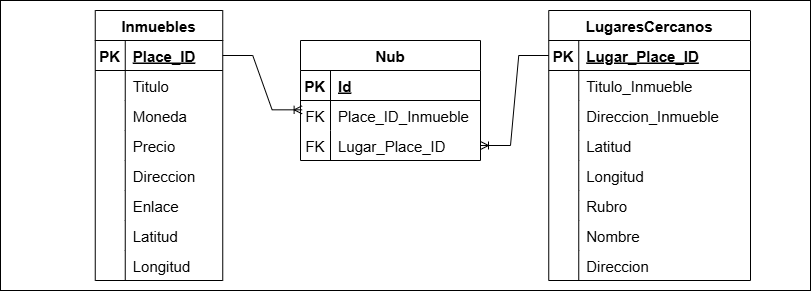

In [ ]:
# Modelo Relacional
Image(filename='ModelosRelacionales/ModeloRelacional.drawio.png') # Cargar la imagen que se encuentra guardada en la carpeta ModelosRelacionales

#### **Modelo Entidad-Relación**

El modelo entidad-relación proporciona una visualización más clara de las relaciones entre las tablas. En este modelo, se pueden identificar fácilmente las claves primarias y foráneas que establecen dichas relaciones. La relación entre las tablas es de muchos a muchos, lo que significa que para un inmueble existen varios lugares cercanos asociados, de igual forma ocurre para lugares cercanos en relación con los inmuebles. 

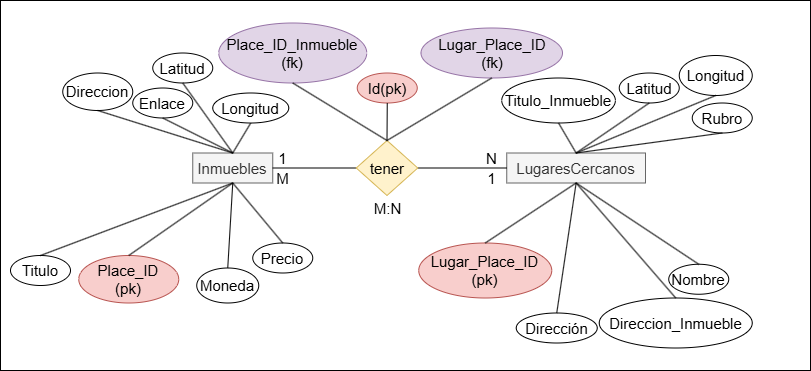

In [27]:
# Modelo Entidad Relación
Image(filename='ModelosRelacionales/Modelos-ModeloEntidadRelacion.drawio.png') # Cargar la imagen que se encuentra guardada en la carpeta ModelosRelacionales

#### **Conexión y Creación de la base de datos**

Con las relaciones entre las tablas claramente definidas, se implementa la conexión y creación de la base de datos `ProyectoFinal.db`. También se utiliza la variable cursor para la ejecución de los comandos SQL.

In [11]:
# Conexión a la base de datos SQLite
conn = sqlite3.connect('ProyectoFinal.db')

# Cursor, para ejecutar comandos SQL
cursor = conn.cursor()

#### **Creación de Tablas**

Se define el esquema SQL para crear las tablas únicamente si aún no existen. A continuación, se detallan los datos que contienen dichas tablas:

* **Tabla Inmuebles:**
    -	Place_ID (String): Identificador único del inmueble (Primary Key).
    -	Titulo (String): Nombre o descripción del inmueble.
    -	Moneda (String): Moneda en la que se expresa el precio.
    -	Precio (Integer): Precio del inmueble.
    -	Direccion (String): Dirección del inmueble.
    -	Enlace (String): link relacionado con el inmueble.
    -	Latitud (Integer): Coordenada de latitud del inmueble.
    -	Longitud (Integer): Coordenada de longitud del inmueble.

* **Tabla LugaresCercanos:**
    -	Lugar_Place_ID (String): Identificador único del lugar (Primary Key).
    -	Titulo_Inmueble (String): Nombre o descripción del inmueble.
    -	Direccion_Inmueble (String):
    -	Latitud (Integer): Coordenada de latitud del lugar.
    -	Longitud (Integer): Coordenada de longitud del lugar.
    -	Rubro (String): Categoría o tipo del lugar. 
    -	Nombre (String): Nombre o descripción del lugar. 
    -	Direccion (String): Dirección de lugar.

* **Tabla Nub:** Correspondiente a la relación de las dos tablas.
    -	Id (String): Clave primaria que identifica cada relación entre las tablas.
    -	Place_ID_Inmueble (String): Clave foránea, que hace referencia a la tabla Inmuebles.
    -	Lugar_Place_ID (String): Clave foránea, que hace referencia a la tabla LugaresCercanos.

In [32]:
# Crear tablas
esquema_sql = '''
CREATE TABLE IF NOT EXISTS Inmuebles (
    Place_ID TEXT PRIMARY KEY,
    Titulo TEXT,
    Moneda TEXT,
    Precio INTEGER,
    Direccion TEXT,
    Enlace TEXT, 
    Latitud INTEGER,
    Longitud INTEGER
);

CREATE TABLE IF NOT EXISTS LugaresCercanos (
    Lugar_Place_ID TEXT PRIMARY KEY,
    Titulo_Inmueble TEXT,
    Direccion_Inmueble TEXT,
    Latitud INTEGER,
    Longitud INTEGER,
    Rubro TEXT,
    Nombre TEXT,
    Direccion TEXT  
);

CREATE TABLE IF NOT EXISTS Nub (
    Id TEXT PRIMARY KEY,
    Place_ID_Inmueble TEXT,
    Lugar_Place_ID TEXT,
    FOREIGN KEY (Place_ID_Inmueble) REFERENCES Inmuebles(Place_ID),
    FOREIGN KEY (Lugar_Place_ID) REFERENCES LugaresCercanos(Lugar_Place_ID)   
);
'''
# Ejecutar el esquema SQL
cursor.executescript(esquema_sql)

# Confirmar los cambios 
conn.commit()

#### **Inserción de datos a las respectivas tablas**

* **Tabla Inmuebles**

In [16]:
# Insetar los datos en la tabla inmuebles
for i, rox in df.iterrows():
    cursor.execute('''
        INSERT OR REPLACE INTO Inmuebles(Place_Id, Titulo, Moneda, Precio, Direccion, Enlace, Latitud, Longitud)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?)         
        ''', (row['Place_ID'], row['Título'], row['Moneda'], row['Precio'], row['Dirección'], row['Enlace'], row['Latitud'], row['Longitud']))

# Confirmar los cambios 
conn.commit()

NameError: name 'df' is not defined

* **Tabla Lugares Cercanos**

In [ ]:
# Insetar los datos en la tabla Lugares Cercanos
for i, rox in df_lugares.iterrows():
    cursor.execute('''
        INSERT OR REPLACE INTO LugaresCercanos(Lugar_Place_ID, Titulo_Inmueble, Direccion_Inmueble, Latitud, Longitud, Rubro, Nombre, Direccion)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?)         
        ''', ( row['Lugar_Place_ID'], row['Título_Inmueble'], row['Dirección_Inmueble'], row['Latitud'], row['Longitud'], row['Rubro'], row['Nombre'], row['Direccion']))

# Confirmar los cambios 
conn.commit()

#### **Consultas SQL**

* ¿Cuál es el valor promedio de los 20 arriendos de dpto más baratos de “x comuna”?

* ¿Cuál es la mediana de comentarios (user_ratings_total), de aquellos lugares cercanos,que tenen una valoración igual o superior a 4 estrellas y que corresponden a los 15 dptos más baratos de “x comuna”?

# **CONCLUSIONES**